
# **Lecture 5 Lab Notebook**

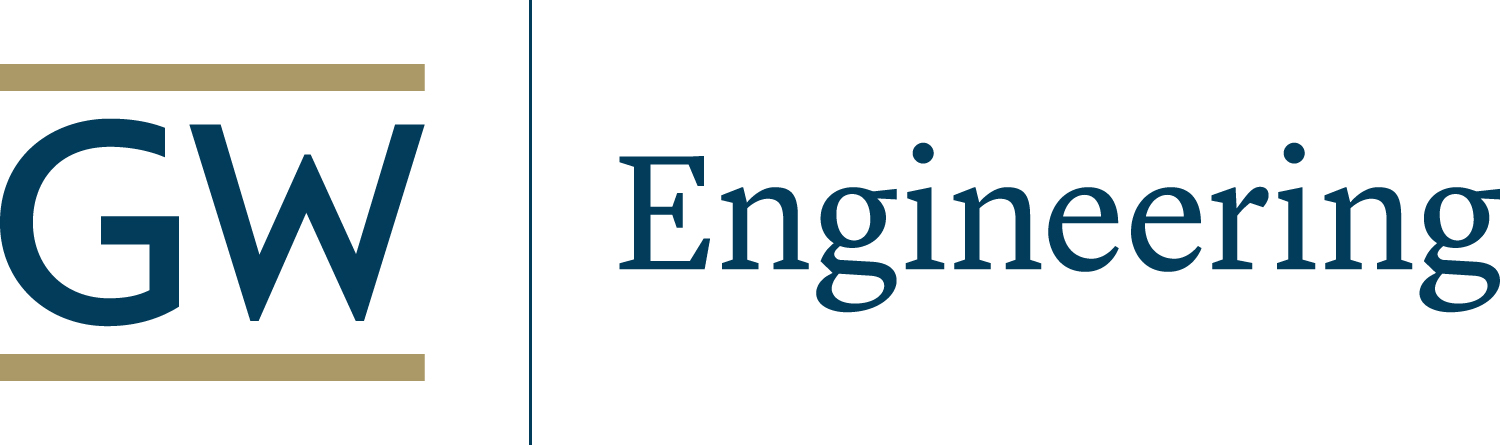

In [ ]:
import subprocess
import sys

# List of required libraries
required_libraries = [
    'numpy',
    'pandas',
    'scikit-learn',S
    'matplotlib',
    'seaborn'
]

# Function to install missing libraries
def install_libraries(libraries):
    for lib in libraries:
        try:
            # Try importing the library
            __import__(lib)
        except ImportError:
            print(f"{lib} not found. Installing...")
            if 'get_ipython' in globals():
                get_ipython().run_line_magic('pip', f'install {lib}')
            else:
                subprocess.check_call([sys.executable, '-m', 'pip', 'install', lib])

# Run the installation function
install_libraries(required_libraries)


scikit-learn not found. Installing...
Note: you may need to restart the kernel to use updated packages.


In [41]:
# Core libraries
import numpy as np
import pandas as pd

# Visualization
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D  # Needed for 3D plotting
import seaborn as sns

# scikit-learn models
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor
from sklearn.svm import OneClassSVM
from sklearn.cluster import DBSCAN

# Preprocessing
from sklearn.preprocessing import StandardScaler

# Evaluation and metrics
from sklearn.metrics import (
    classification_report,
    accuracy_score,
    confusion_matrix,
    ConfusionMatrixDisplay,
    roc_curve,
    auc,
    make_scorer,
    f1_score
)

# Data split and model selection
from sklearn.model_selection import train_test_split, GridSearchCV

# Dimensionality reduction
from sklearn.decomposition import PCA

# Sample data generator
from sklearn.datasets import make_blobs



Lets generate some sythetic data to learn with

In [3]:
# Parameters
n_samples = 10000
n_outliers = int(0.05 * n_samples)  # 5% outliers
n_inliers = n_samples - n_outliers
n_features = 20  # Number of features
purturbation = 2
# Generate inliers
X_inliers, y_inliers = make_blobs(
    n_samples=n_inliers, centers=3, n_features=n_features, cluster_std=1.5, random_state=42
)

# Generate outliers harder to detect (within the same distribution as inliers)
X_outliers = X_inliers[np.random.choice(X_inliers.shape[0], n_outliers, replace=False)]
X_outliers += np.random.normal(0, purturbation, size=X_outliers.shape)  # Slight random perturbation

# Combine inliers and outliers
X = np.vstack((X_inliers, X_outliers))
y = np.hstack((np.zeros(n_inliers), np.ones(n_outliers)))  # 0 for inliers, 1 for outliers

# Convert to DataFrame for exploration
columns = [f"Feature{i+1}" for i in range(n_features)]
df = pd.DataFrame(X, columns=columns)
df["Class"] = y
print(df.head())
print(f"Shape of dataset: {df.shape}")


   Feature1  Feature2  Feature3  Feature4  Feature5  Feature6  Feature7  \
0  3.940341 -5.627795 -5.400168 -2.874870 -0.303714  6.925473 -5.724213   
1 -8.304869  0.226904 -7.887974  5.950937 -3.133699  3.379946 -3.936539   
2 -3.352420  8.568961  5.172261  4.165096 -7.133306 -8.174301 -5.960024   
3 -7.023209  7.691721  3.848275  0.239702 -6.016757 -8.046281 -8.120688   
4 -3.235747  6.737443  6.993928  1.095063 -8.193996 -7.546760 -7.445081   

   Feature8  Feature9  Feature10  ...  Feature12  Feature13  Feature14  \
0  2.015699  1.731386  -6.750876  ...  -6.480604  -8.136016   7.567211   
1  0.005197  3.138350  -6.829766  ...   4.706732   8.832867   8.175991   
2  7.526849  1.863409   4.269203  ...   9.330089   7.788265  -3.923037   
3  5.473543  3.386129   2.246728  ...  11.254091   5.365012  -3.117824   
4  7.492863  0.834801   4.775176  ...   9.362550   6.296711  -4.229404   

   Feature15  Feature16  Feature17  Feature18  Feature19  Feature20  Class  
0   9.055622   6.436444  -2

In [4]:
LABELS = ["Normal", "Fraud"]

In [ ]:
# df = pd.read_csv('../data/creditcard.csv')

C:\Users\cleme\AppData\Local\Temp\ipykernel_14668\2266408853.py:1: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  count_classes = pd.value_counts(df['Class'], sort = True)


Text(0, 0.5, 'Frequency')

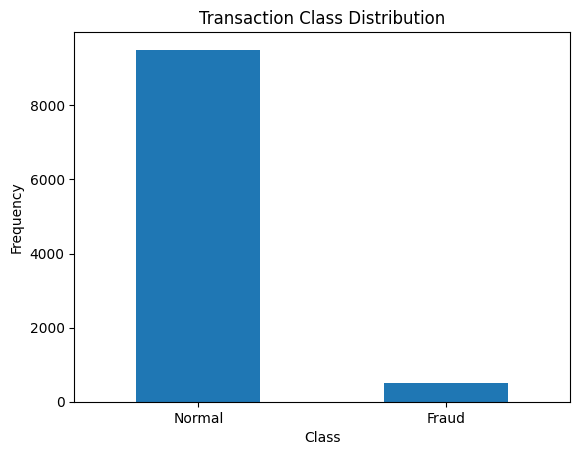

In [7]:
count_classes = pd.value_counts(df['Class'], sort = True)
count_classes.plot(kind = 'bar', rot=0)
plt.title("Transaction Class Distribution")
plt.xticks(range(2), LABELS)
plt.xlabel("Class")
plt.ylabel("Frequency")

In [8]:
imbalance = (df['Class'] == 1).sum() / ((df['Class'] == 0).sum() + (df['Class'] == 1).sum())
print(f"The class imbalance is {imbalance}")

The class imbalance is 0.05


In [9]:
X = df.drop(columns = 'Class')
y = df['Class']

In [10]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y) #stratify retains the class balance - important for imbalnced data

In [11]:
len(X_test)

3000

In [12]:
len(X_train)

7000

In [13]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test) # do not fit transform the test set.  only transform.

In [14]:
# Define the custom F1 scorer function (directly handle y_true and predictions)

from sklearn.metrics import f1_score, make_scorer

# Define the Isolation Forest model
iforest = IsolationForest()
# Define the One-Class SVM model
ocsvm = OneClassSVM()

# Use GridSearchCV with the custom F1 scorer
param_grid_iforest = {
    'n_estimators': [50, 100],
    'max_samples': [.5, 0.75],
    'contamination': [.01, .05, .1],
    'max_features': [0.5, .75]
}

# Define the parameter grid
param_grid_ocsvm = {
    'kernel': ['linear', 'poly'],  # Different kernels
    'nu': [0.01, .05, .1],  # The fraction of outliers
    # 'gamma': [0.1, 1],  # Only for 'rbf' kernel
    'degree': [2, 3, 4, 5],  # Only for 'poly' kernel
    'max_iter': [-1] #keep going till converges
}



In [15]:

def anomaly_f1_iforest(estimator, X, y_true):
    # IsolationForest returns 1 for inlier, -1 for outlier
    y_pred = estimator.predict(X)
    
    # Flip to 1 = anomaly, 0 = normal (to match y_true)
    y_pred = [1 if p == -1 else 0 for p in y_pred]
    
    return f1_score(y_true, y_pred)

def anomaly_f1_ocsvm(estimator, X, y_true):
    # OCSVM returns 1 for inlier, -1 for outlier
    y_pred = estimator.predict(X)
    
    # Flip to 1 = anomaly, 0 = normal (to match y_true)
    y_pred = [1 if p == -1 else 0 for p in y_pred]
    
    return f1_score(y_true, y_pred)


In [16]:
# Use it in GridSearchCV
# scorer_iforest = make_scorer(anomaly_f1_iforest)
# scorer_ocsvm = make_scorer(anomaly_f1_ocsvm)

In [17]:
# GridSearchCV for Isolation Forest
grid_iforest = GridSearchCV(iforest, param_grid_iforest, scoring=anomaly_f1_iforest, cv=5, verbose=2)
grid_iforest.fit(X_train_scaled, y_train)  # y must have 1 = anomaly, 0 = normal


Fitting 5 folds for each of 24 candidates, totalling 120 fits


GridSearchCV(cv=5, estimator=IsolationForest(),
             param_grid={'contamination': [0.01, 0.05, 0.1],
                         'max_features': [0.5, 0.75],
                         'max_samples': [0.5, 0.75],
                         'n_estimators': [50, 100]},
             scoring=<function anomaly_f1_iforest at 0x000001A7AD1F1A80>,
             verbose=1)

In [18]:

grid_ocsvm = GridSearchCV(ocsvm, param_grid_ocsvm, scoring=anomaly_f1_ocsvm, cv=5, verbose=2)
grid_ocsvm.fit(X_train_scaled, y_train)  # y must have 1 = anomaly, 0 = normal


Fitting 5 folds for each of 24 candidates, totalling 120 fits
[CV] END ......degree=2, kernel=linear, max_iter=-1, nu=0.01; total time=   0.0s
[CV] END ......degree=2, kernel=linear, max_iter=-1, nu=0.01; total time=   0.0s
[CV] END ......degree=2, kernel=linear, max_iter=-1, nu=0.01; total time=   0.0s
[CV] END ......degree=2, kernel=linear, max_iter=-1, nu=0.01; total time=   0.0s
[CV] END ......degree=2, kernel=linear, max_iter=-1, nu=0.01; total time=   0.0s
[CV] END ......degree=2, kernel=linear, max_iter=-1, nu=0.05; total time=   0.0s
[CV] END ......degree=2, kernel=linear, max_iter=-1, nu=0.05; total time=   0.0s
[CV] END ......degree=2, kernel=linear, max_iter=-1, nu=0.05; total time=   0.0s
[CV] END ......degree=2, kernel=linear, max_iter=-1, nu=0.05; total time=   0.0s
[CV] END ......degree=2, kernel=linear, max_iter=-1, nu=0.05; total time=   0.0s
[CV] END .......degree=2, kernel=linear, max_iter=-1, nu=0.1; total time=   0.0s
[CV] END .......degree=2, kernel=linear, max_it

GridSearchCV(cv=5, estimator=OneClassSVM(),
             param_grid={'degree': [2, 3, 4, 5], 'kernel': ['linear', 'poly'],
                         'max_iter': [-1], 'nu': [0.01, 0.05, 0.1]},
             scoring=<function anomaly_f1_ocsvm at 0x000001A7AD1F2160>,
             verbose=2)

In [19]:
best_model_iforest = grid_iforest.best_estimator_
best_model_ocsvm = grid_ocsvm.best_estimator_

# Output best parameters and best F1 score
print("Best iforest Parameters:", grid_iforest.best_params_)
print("Best iforest F1 Score:", grid_iforest.best_score_)

print("Best ocsvm Parameters:", grid_ocsvm.best_params_)
print("Best ocsvm F1 Score:", grid_ocsvm.best_score_)


Best iforest Parameters: {'contamination': 0.05, 'max_features': 0.75, 'max_samples': 0.5, 'n_estimators': 100}
Best iforest F1 Score: 0.8169805324217793
Best ocsvm Parameters: {'degree': 3, 'kernel': 'poly', 'max_iter': -1, 'nu': 0.01}
Best ocsvm F1 Score: 0.1968395338233825


In [20]:
grid_iforest.best_estimator_

IsolationForest(contamination=0.05, max_features=0.75, max_samples=0.5)

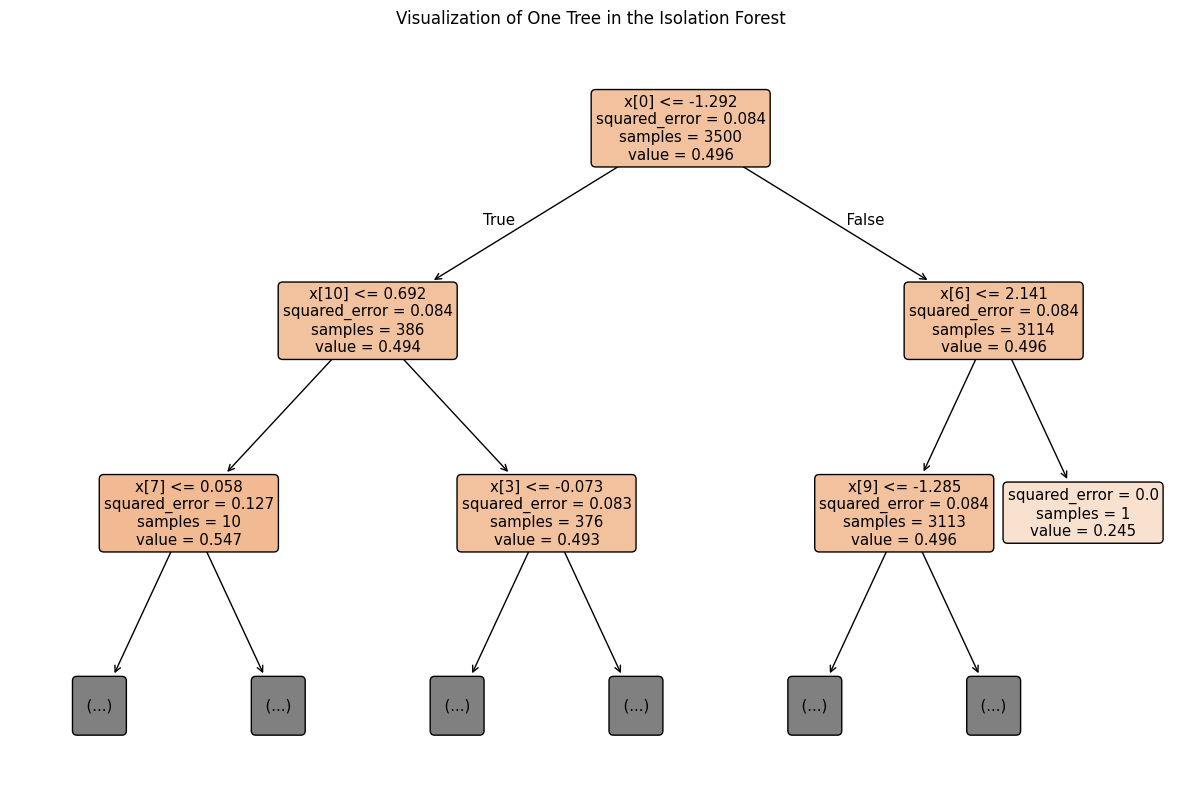

In [21]:
from sklearn.tree import plot_tree

tree = best_model_iforest.estimators_[0]  # Get the first tree

# Visualize the tree
plt.figure(figsize=(15, 10))
plot_tree(tree, filled=True, rounded=True, max_depth=2)
plt.title("Visualization of One Tree in the Isolation Forest")
plt.show()

Principal component analysis, or PCA, is a dimensionality reduction method that is often used to reduce the dimensionality of large data sets, by transforming a large set of variables into a smaller one that still contains most of the information in the large set.

Reducing the number of variables of a data set naturally comes at the expense of accuracy, but the trick in dimensionality reduction is to trade a little accuracy for simplicity. Because smaller data sets are easier to explore and visualize, and thus make analyzing data points much easier and faster for machine learning algorithms without extraneous variables to process.

https://builtin.com/data-science/step-step-explanation-principal-component-analysis

In [22]:
classifiers = {
    "Isolation Forest":best_model_iforest,
    "One Class SVM":best_model_ocsvm
}

Classification Report :
              precision    recall  f1-score   support

         0.0       0.99      0.99      0.99      2850
         1.0       0.75      0.75      0.75       150

    accuracy                           0.97      3000
   macro avg       0.87      0.87      0.87      3000
weighted avg       0.98      0.97      0.98      3000



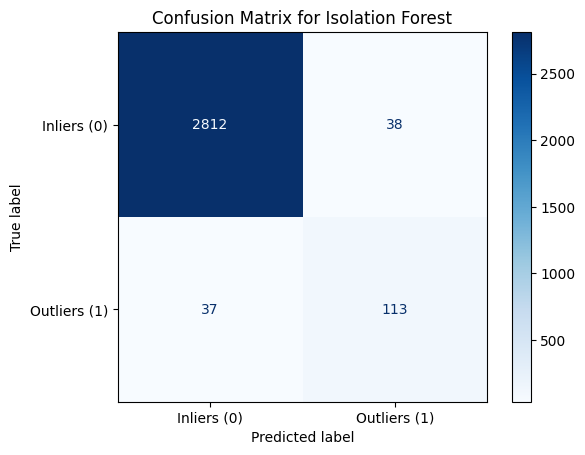

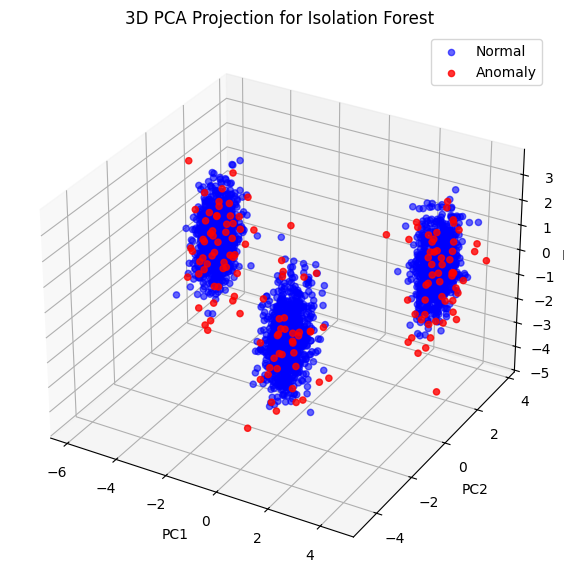

Classification Report :
              precision    recall  f1-score   support

         0.0       0.95      0.99      0.97      2850
         1.0       0.28      0.08      0.12       150

    accuracy                           0.94      3000
   macro avg       0.62      0.53      0.55      3000
weighted avg       0.92      0.94      0.93      3000



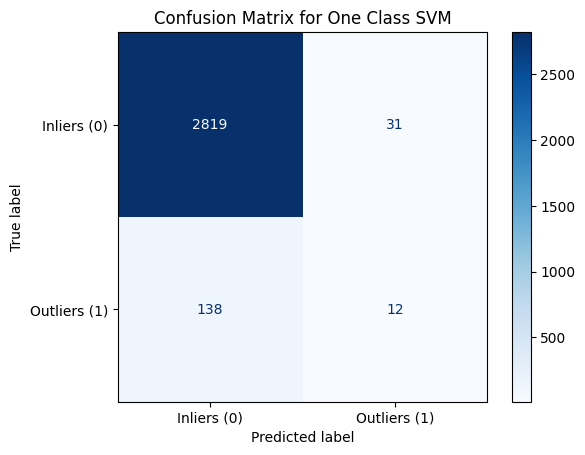

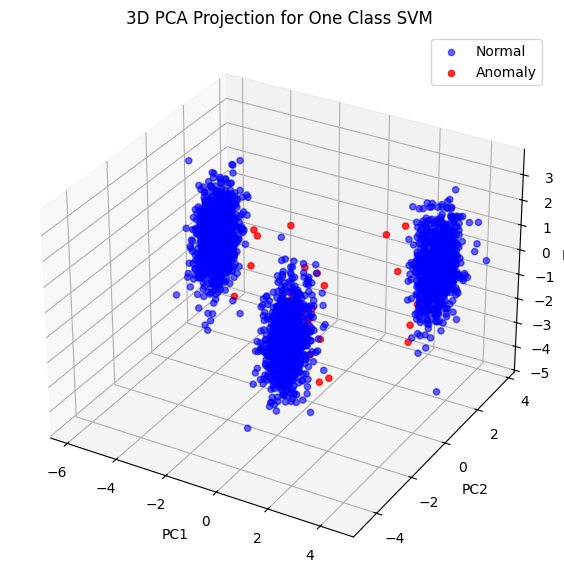

In [34]:
for i, (clf_name,clf) in enumerate(classifiers.items()):
    if (clf_name == "One Class SVM") or (clf_name == "Isolation Forest"):
        y_pred = clf.predict(X_test_scaled)
        y_pred = np.where(y_pred == 1, 0, 1)

    print("Classification Report :")
    print(classification_report(y_test,y_pred))

    # Compute confusion matrix
    conf_matrix = confusion_matrix(y_test, y_pred)

    # Display the confusion matrix
    disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=["Inliers (0)", "Outliers (1)"])
    disp.plot(cmap='Blues', values_format='d')
    plt.title(f"Confusion Matrix for {clf_name}")
    plt.show()

    # Reduce to 3D with PCA
    pca = PCA(n_components=3)
    X_pca = pca.fit_transform(X_test_scaled)

    # Split based on predicted labels
    normal = X_pca[y_pred == 0]
    anomaly = X_pca[y_pred == 1]

    # Plot in 3D
    fig = plt.figure(figsize=(10, 7))
    ax = fig.add_subplot(111, projection='3d')

    ax.scatter(normal[:, 0], normal[:, 1], normal[:, 2], c='blue', label='Normal', alpha=0.6)
    ax.scatter(anomaly[:, 0], anomaly[:, 1], anomaly[:, 2], c='red', label='Anomaly', alpha=0.8)

    ax.set_title(f'3D PCA Projection for {clf_name}')
    ax.set_xlabel('PC1')
    ax.set_ylabel('PC2')
    ax.set_zlabel('PC3')
    ax.legend()
    plt.show()